# Lab 4: Experimentación de arquitecturas CNN 

Utilizando Convolutional Neural Networks con Keras, entrenar un clasificador que sea capaz de reconocer personajes en imágenes de los Simpsons con una accuracy en el dataset de validación superior al **90%**. Redactar un informe analizando varias de las alternativas probadas y los resultados obtenidos.

A continuación se detallan una serie de aspectos orientativos que podrían ser analizados en vuestro informe (no es necesario tratar todos ellos ni mucho menos, esto son ideas orientativas de aspectos que podéis explorar):

*   Análisis de los datos a utilizar.
*   Utilización de distintas arquitecturas CNNs, comentando aspectos como su profundidad, hiperparámetros utilizados, optimizador, uso de técnicas de regularización, *batch normalization*, etc. Se deben de realizar como **mínimo *8* experimentos.** Siendo de libre elección.
*  En caso de llegar antes del experimento 8 al **90 %** hay que seguir investigando hasta llegar a los 8 experimentos.
* Si hemos llegado al experimento 8 y no hemos conseguido llegar al **90 %** no hay problema en seguir realizando experimentos hasta llegar al desempeño objetivo.
*  El desempeño a tener en cuenta es el val acurracy, hay que añadir una primera fila con el mejor valor del laboratorio anterior.
*   Análisis  de los errores de la red. ¿Qué tipo de imágenes o qué personajes dan más problemas a nuestro modelo? De 100 imagenes aleatorias del dataset de testing con el valor inferido. Compare un análisis visual con  una matriz de confusión.


Notas: 
* Recuerda partir los datos en training/validation para tener una buena estimación de los valores que nuestro modelo tendrá en los datos de test, así como comprobar que no estamos cayendo en overfitting. Una posible partición puede ser 80 / 20.
* Las imágenes **no están normalizadas**. Hay que normalizarlas como hemos hecho en trabajos anteriores.
* El test set del problema tiene imágenes un poco más "fáciles", por lo que es posible encontrarse con métricas en el test set bastante mejores que en el training set.

## Carga de los datos

In [9]:
import cv2
import os
import numpy as np 
import keras
import matplotlib.pyplot as plt
import glob

user_profile = os.environ['USERPROFILE']
datasets_path = os.path.join(user_profile, '.keras','datasets')

# # Primero, bajamos los datos de entrenamiento
# keras.utils.get_file(fname="simpsons_train.tar.gz", 
#                      origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60")

# # Descomprimimos el archivo
# !tar -xzf /root/.keras/datasets/simpsons_train.tar.gz -C /root/.keras/datasets

# # Hacemos lo mismo con los datos de test
# keras.utils.get_file(fname="simpsons_test.tar.gz", 
#                      origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8")
# !tar -xzf /root/.keras/datasets/simpsons_test.tar.gz -C /root/.keras/datasets

In [2]:
# Esta variable contiene un mapeo de número de clase a personaje.
# Utilizamos sólo los 18 personajes del dataset que tienen más imágenes.
MAP_CHARACTERS = {
    0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson',
    3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel', 
    7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson', 
    11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak', 
    14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'
}

# Vamos a standarizar todas las imágenes a tamaño 64x64
IMG_SIZE = 64

In [3]:
def load_train_set(dirname, map_characters, verbose=True):
    """Esta función carga los datos de training en imágenes.
    
    Como las imágenes tienen tamaños distintas, utilizamos la librería opencv
    para hacer un resize y adaptarlas todas a tamaño IMG_SIZE x IMG_SIZE.
    
    Args:
        dirname: directorio completo del que leer los datos
        map_characters: variable de mapeo entre labels y personajes
        verbose: si es True, muestra información de las imágenes cargadas
     
    Returns:
        X, y: X es un array con todas las imágenes cargadas con tamaño
                IMG_SIZE x IMG_SIZE
              y es un array con las labels de correspondientes a cada imagen
    """
    X_train = []
    y_train = []
    for label, character in map_characters.items():        
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith("jpg")]
        if verbose:
          print("Leyendo {} imágenes encontradas de {}".format(len(images), character))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            X_train.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
            y_train.append(label)
    return np.array(X_train), np.array(y_train)

In [4]:
def load_test_set(dirname, map_characters, verbose=True):
    """Esta función funciona de manera equivalente a la función load_train_set
    pero cargando los datos de test."""
    X_test = []
    y_test = []
    reverse_dict = {v: k for k, v in map_characters.items()}
    for filename in glob.glob(dirname + '/*.*'):
        char_name = "_".join(filename.split('/')[-1].split('_')[:-1])
        if char_name in reverse_dict:
            image = cv2.imread(filename)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            X_test.append(image)
            y_test.append(reverse_dict[char_name])
    if verbose:
        print("Leídas {} imágenes de test".format(len(X_test)))
    return np.array(X_test), np.array(y_test)


In [11]:
# Cargamos los datos. Si no estás trabajando en colab, cambia los paths por
# los de los ficheros donde hayas descargado los datos.
DATASET_TRAIN_PATH_COLAB = datasets_path + "/simpsons"
DATASET_TEST_PATH_COLAB = datasets_path + "/simpsons_testset"

x_train, y_train = load_train_set(DATASET_TRAIN_PATH_COLAB, MAP_CHARACTERS)
x_test, y_test = load_test_set(DATASET_TEST_PATH_COLAB, MAP_CHARACTERS)

Leyendo 913 imágenes encontradas de abraham_grampa_simpson
Leyendo 623 imágenes encontradas de apu_nahasapeemapetilon
Leyendo 1342 imágenes encontradas de bart_simpson
Leyendo 1193 imágenes encontradas de charles_montgomery_burns
Leyendo 986 imágenes encontradas de chief_wiggum
Leyendo 469 imágenes encontradas de comic_book_guy
Leyendo 457 imágenes encontradas de edna_krabappel
Leyendo 2246 imágenes encontradas de homer_simpson
Leyendo 498 imágenes encontradas de kent_brockman
Leyendo 1206 imágenes encontradas de krusty_the_clown
Leyendo 1354 imágenes encontradas de lisa_simpson
Leyendo 1291 imágenes encontradas de marge_simpson
Leyendo 1079 imágenes encontradas de milhouse_van_houten
Leyendo 1452 imágenes encontradas de moe_szyslak
Leyendo 1454 imágenes encontradas de ned_flanders
Leyendo 358 imágenes encontradas de nelson_muntz
Leyendo 1194 imágenes encontradas de principal_skinner
Leyendo 877 imágenes encontradas de sideshow_bob
Leídas 0 imágenes de test


In [12]:
# Vamos a barajar aleatoriamente los datos. Esto es importante ya que si no
# lo hacemos y, por ejemplo, cogemos el 20% de los datos finales como validation
# set, estaremos utilizando solo un pequeño número de personajes, ya que
# las imágenes se leen secuencialmente personaje a personaje.
perm = np.random.permutation(len(x_train))
x_train, y_train = x_train[perm], y_train[perm]

In [13]:
# Definición de funciones que permitirán la visualización de las graficas de entrenamiento
def plot_acc(history, title="Model Accuracy"):
    """Imprime una gráfica mostrando la accuracy por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Entrenamiento', 'Validación'], loc='upper left')
    plt.show()
    
def plot_loss(history, title="Model Loss"):
    """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Entrenamiento', 'Validación'], loc='upper right')
    plt.show()
    
def plot_compare_losses(history1, history2, name1="Red 1",
                        name2="Red 2", title="Graph title"):
    """Compara losses de dos entrenamientos con nombres name1 y name2"""
    plt.plot(history1.history['loss'], color="green")
    plt.plot(history1.history['val_loss'], 'r--', color="green")
    plt.plot(history2.history['loss'], color="blue")
    plt.plot(history2.history['val_loss'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Entrenamiento ' + name1, 'Validación ' + name1, 
                'Entrenamiento ' + name2, 'Validación ' + name2],
               loc='upper right')
    plt.show()
    
def plot_compare_accs(history1, history2, name1="Red 1",
                      name2="Red 2", title="Graph title"):
    """Compara accuracies de dos entrenamientos con nombres name1 y name2"""
    plt.plot(history1.history['accuracy'], color="green")
    plt.plot(history1.history['val_accuracy'], 'r--', color="green")
    plt.plot(history2.history['accuracy'], color="blue")
    plt.plot(history2.history['val_accuracy'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2], 
               loc='lower right')
    plt.show()
    


In [15]:
val_acc_lab3=0.72914
val_loss_lab3= 2.27094

from prettytable import PrettyTable
 
myTable = PrettyTable(["Experimento", "Accuracy", "Loss"])
 
# Add rows
myTable.add_row(["0", "{0:.5f}".format(val_acc_lab3), "{0:.5f}".format(val_loss_lab3)])
print(myTable)

+-------------+----------+---------+
| Experimento | Accuracy |   Loss  |
+-------------+----------+---------+
|      0      | 0.72914  | 2.27094 |
+-------------+----------+---------+


## Realización de los experimentos

Primeramente vamos a visualizar aleatoriamente algunas imagenes del dataset de training junto con su etiqueta.

In [16]:
# Asociación de valor etiqueta con su la descripción de la prenda
nombre_personajes = ['abraham_grampa_simpson', 'apu_nahasapeemapetilon', 'bart_simpson', 'charles_montgomery_burns', 'chief_wiggum',
                     'comic_book_guy', 'edna_krabappel', 'homer_simpson', 'kent_brockman', 'krusty_the_clown', 'lisa_simpson', 
                     'marge_simpson', 'milhouse_van_houten', 'moe_szyslak', 'ned_flanders', 'nelson_muntz', 'principal_skinner',
                     'sideshow_bob']
print (nombre_personajes)

['abraham_grampa_simpson', 'apu_nahasapeemapetilon', 'bart_simpson', 'charles_montgomery_burns', 'chief_wiggum', 'comic_book_guy', 'edna_krabappel', 'homer_simpson', 'kent_brockman', 'krusty_the_clown', 'lisa_simpson', 'marge_simpson', 'milhouse_van_houten', 'moe_szyslak', 'ned_flanders', 'nelson_muntz', 'principal_skinner', 'sideshow_bob']


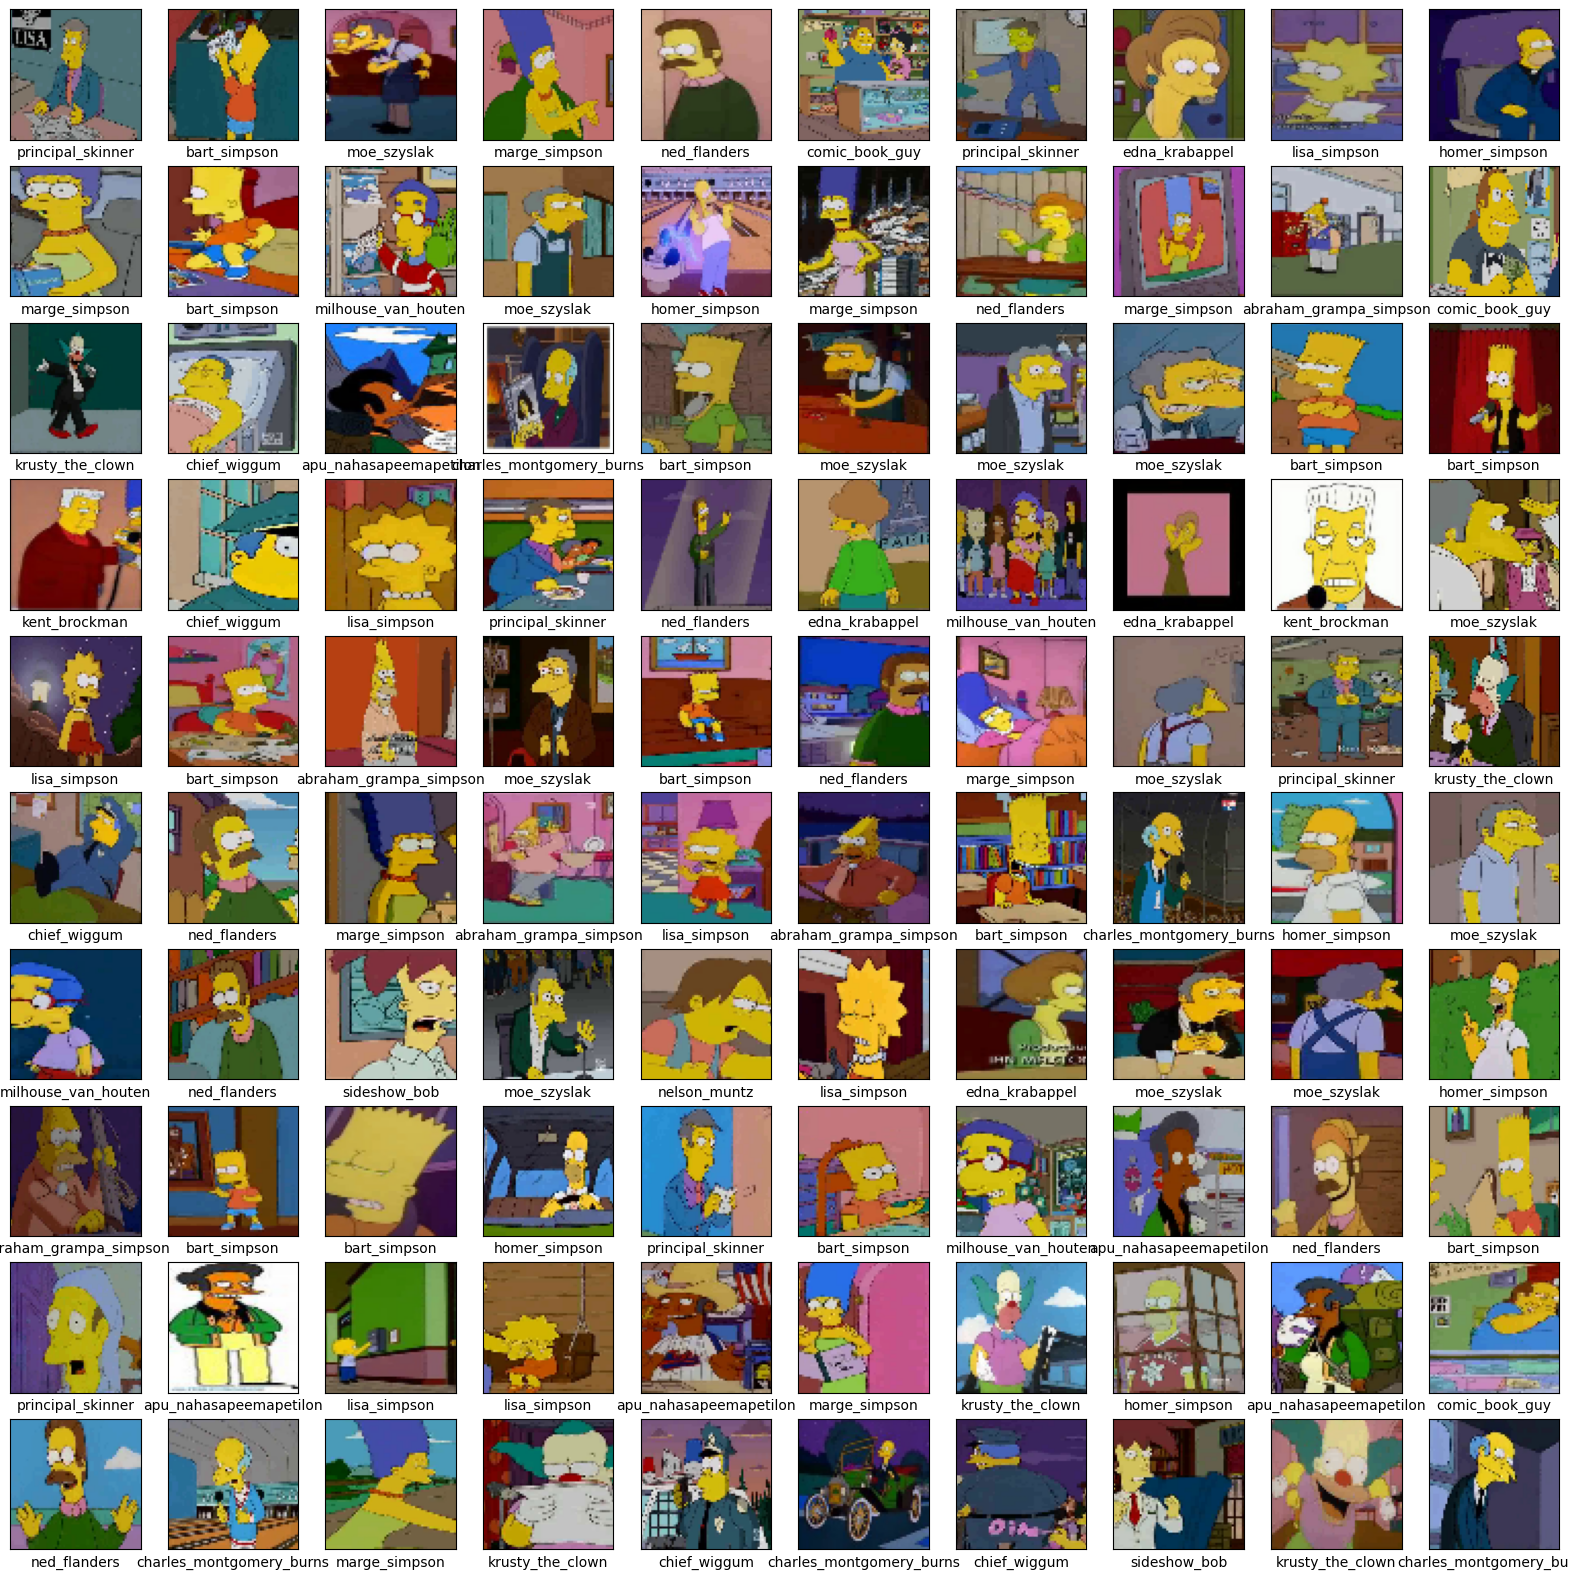

In [17]:
from random import sample
lista = range(0,len(x_train))
lista_aleatoria=sample(lista,k=100)
j=0


# Ajustamos el tamaño de imagen
plt.figure(figsize=(20,20))
# Seleccionamos las 100 primeras imagenes
for i in lista_aleatoria:
    # Las visulizamos en 10 filas y 10 columnas
    plt.subplot(10,10,j+1)
    j=j+1
    plt.xticks([])
    plt.yticks([])
    # Omitimos el grid
    plt.grid(False)
    # Conversión de la imagen de BGR a RGB
    img = cv2.cvtColor(x_train[i], cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    # Añadimos a cada imagen su etiqueta
    plt.xlabel(nombre_personajes[y_train[i]])

# Finalmente visualizamos
plt.show()

In [18]:
# Commprobamos el número de imagenes junto con su formato
x_train.shape

(18992, 64, 64, 3)

In [19]:
# Normalización
x_train = x_train / 255.0
x_test = x_test / 255.0

### Experimento 1

In [ ]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(64,(2,2), activation='relu', input_shape=(64, 64, 3), padding='same'))
model.add(layers.Conv2D(64,(2,2), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Conv2D(128,(2,2), activation='relu', padding='same'))
model.add(layers.Conv2D(128,(2,2), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(18, activation='softmax'))

#### Conclusión

### Experimento 2

#### Conclusión

### Experimento 3

#### Conclusión

### Experimento 4

#### Conclusión

### Experimento 5

#### Conclusión

### Experimento 6

#### Conclusión

### Experimento 7

#### Conclusión

### Experimento 8

#### Conclusión

##Análisis de los errores de la red. 